# NDReg

## Preface
I am completing this algorithms MD to the extent of my current knowledge. I will be meeting with Kwame on Tuesday 1/17 in order to fill in the gaps in my knowledge and obtain a more comprehensive understanding of the algorithm. 

## Algorithm
### Description
NDReg is an algorithm designed to calculate one or more coordinate transformations with the goal of aligning two images of the same scene. For our specific application, NDreg will be used to track specific synapses over time, such that stochastic statistics can be generated about the subject's synaptic activity.

### Inputs
- inImg_ds -> The image two be aligned
- refImage_ds -> The image which inImg_ds is being aligned to
- iterations -> The number of iterations to run the algorithm
- useMI -> Whether or not to use MI (Mutual Information)
- verbose -> Whether or not to print progress and debug data

### Outputs
- The parameters of an affine transform that maps the inImg_ds to the refImage_ds

### Function

In [3]:
####################################################
###PSEUDOCODE WILL GO HERE ONCE I MEET WITH KWAME###
####################################################

### Analysis
#### Qualitative Visualizations
I will display the input and base image to be passed to the register function, and the result of applying the register function's output to the input image.

#### Quantitative Score
I will use the following loss function (sum of squared errors) to evaluate the success of the algorithm:
$\Sigma_{voxels}L_2(inputImage[voxel] - baseImage[voxel])$

#### Summary Score
I will use the average percent reduction in squared error over a series of tests to summarize the quantitative performance of the algorithm.

#### Null Comparison
I will compare the results of the register function to a function which generates and applies a random rigid body transformation in order to demonstrate how well the algorithm performes compared to random guessing.



### Write Code

In [1]:
import sys
sys.path.insert(0, '../../../ndreg/')
import ndreg

def register(inImg, baseImg):
    return ndreg.imgAffineComposite(inImg,
                              baseImg,
                              iterations=200,
                              useMI=True,
                              verbose=False)

## Simulation
### Functionality Testing
NDReg functionality tests will be performed in order to verify that the register funciton is working as expected.

#### 1. Generate Data

In [5]:
refImg = ndreg.imgDownload('ara_ccf2')
refAnnoImg = ndreg.imgDownload('ara_ccf2', channel="annotation")
inImg = ndreg.imgDownload('eacker01', 'r', 5)

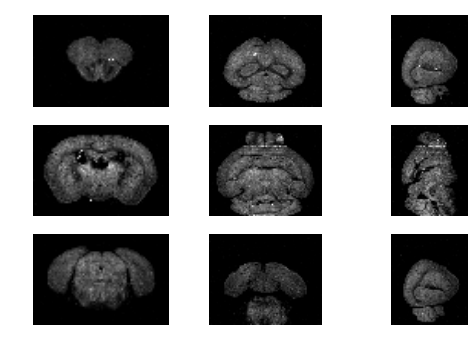

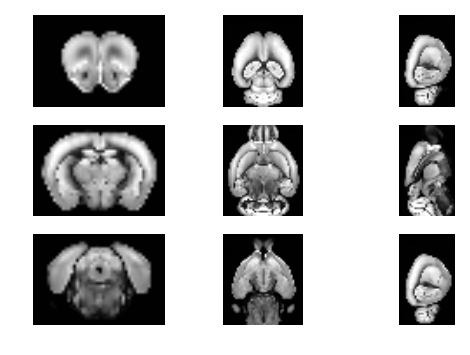

In [6]:
#reorient and rescale the test image
inImgReor = ndreg.imgReorient(inImg, 'lsp', 'rsa')
inImg_ds = ndreg.imgResample(inImgReor, spacing=[.25, .25, .25])
refImg_ds = ndreg.imgResample(refImg, spacing=[.25, .25, .25])

#display the images to be registered
ndreg.imgShow(inImg_ds, vmax=10000)
ndreg.imgShow(refImg_ds, vmax=500)

#### 2. Generate Results

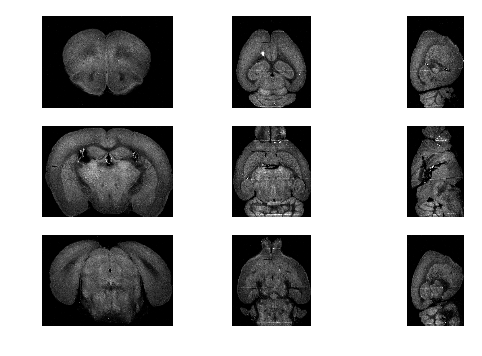

In [7]:
affine = register(inImg_ds, refImg_ds)
resultImage = ndreg.imgApplyAffine(inImgReor,
                                   affine,
                                   size=refImg.GetSize(),
                                   spacing=refImg.GetSpacing())
ndreg.imgShow(resultImage, vmax=10000)

#### 3. Analyze Results
The results of this functionality test are consistent with those of the NDReg documentation. I can now proceed to the validation testing phase. 

### Validation Testing
#### 1. Generate Data
The following code will generate two 100x100x100 volumes randomly populated with synapses and noise modeling that of the real world data, and then apply a random rigid body transformation to one of the volumes. The volumes will then be run thorugh the register algorithm in order to attemt to align them again.

In [2]:
import math
import numpy as np
import SimpleITK as itk
from random import randrange as rand
from random import uniform as floatRand
from affine import Affine

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 2):
        for y in range(-1, 2):
            for x in range(-1, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)               
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                        
                if valid:
                    toPopulate.append(curPoint)
            
    return set(toPopulate)                       
   
def getTransform():
    #generate a random rigid body transform
    #error is assumed to be 5% rotationally
    #and laterally
    a = floatRand(-.075, .075)
    b = floatRand(-.075, .075)
    c = floatRand(-.075, .075)
    xt = floatRand(-2.5, 2.5)
    yt = floatRand(-2.5, 2.5)
    zt = floatRand(-2.5, 2.5)
    transform = np.stack([
        [math.cos(a)*math.cos(b), math.cos(a)*math.sin(b)*math.sin(c)-math.sin(a)*math.cos(c), math.cos(a)*math.sin(b)*math.cos(c)+math.sin(a)*math.sin(c), xt],
        [math.sin(a)*math.cos(b), math.sin(a)*math.sin(b)*math.sin(c)+math.cos(a)*math.cos(c), math.sin(a)*math.sin(b)*math.cos(c)-math.cos(a)*math.sin(c), yt],
        [-math.sin(b), math.cos(b)*math.sin(c), math.cos(b)*math.cos(c), zt],
        [0., 0., 0., 1.]
    ])
    return transform
    
    
def applyRigid(initialVolume, transform):
    rigidMatrix = np.zeros_like(initialVolume)    
    for z in range(initialVolume.shape[0]):
        for y in range(initialVolume.shape[1]):
            for x in range(initialVolume.shape[2]):
                new = np.dot(transform, [x, y, z, 1])
                try:
                    rigidMatrix[int(new[2])][int(new[1])][int(new[0])] = initialVolume[z][y][x]
                #if transformed place is out of bounds, dont deal with it
                except IndexError:
                        continue
    return rigidMatrix
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
        
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
      
    #convert numpy array to itk image
    itkVolume = itk.GetImageFromArray(noiseVolume)
    
    #perform a random rigid body transform to generate the second volume
    transform = getTransform()
    rigidMatrix = applyRigid(noiseVolume, transform)
    
    rigidVolume = itk.GetImageFromArray(rigidMatrix)
    return itkVolume, rigidVolume, transform

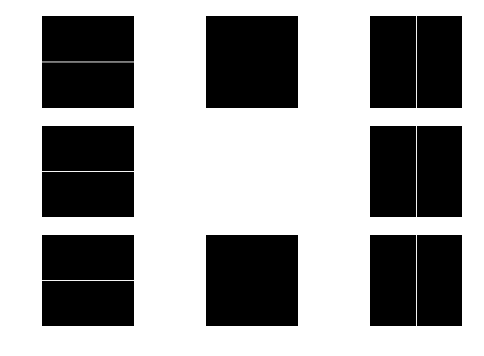

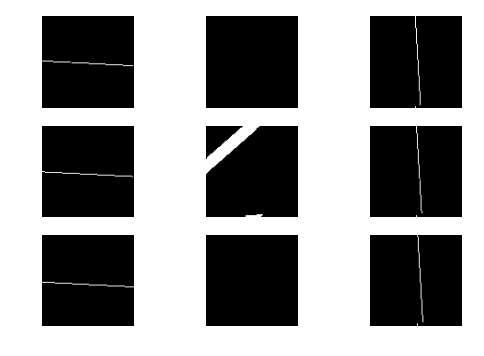

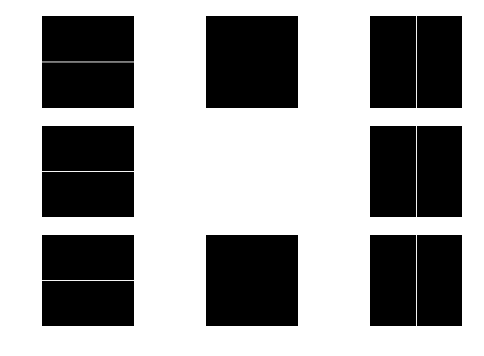

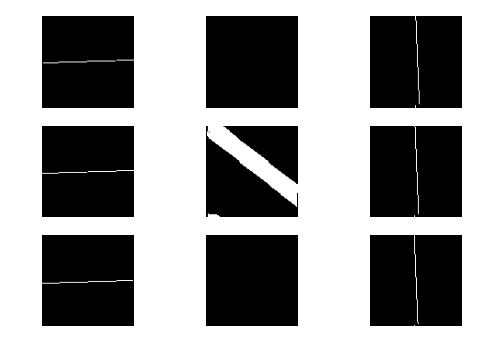

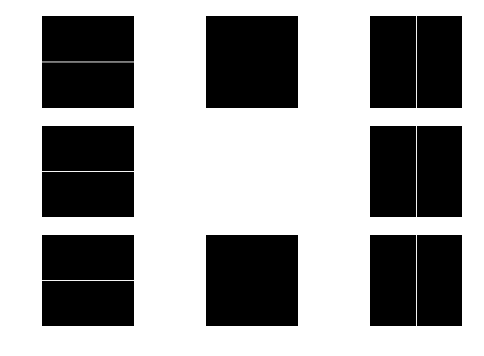

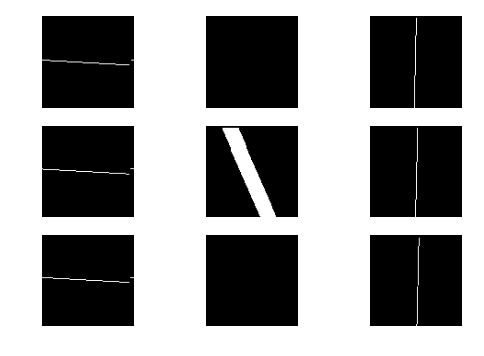

In [3]:
#a quick functionality test for the random rigid

for i in range(3):
    this = np.zeros((100, 100, 100))
    for x in range(0, 100):
        for z in range(0, 100):
            this[z][50][x] = 60000
    
    transform = getTransform()
    that = applyRigid(this, transform)   
    those = itk.GetImageFromArray(that)
    ndreg.imgShow(itk.GetImageFromArray(this), vmax=60000)
    ndreg.imgShow(those, vmax=60000)


Executing Test:  1
[[ 0.99698225  0.0594079   0.04997099  0.89749873]
 [-0.06224528  0.99641569  0.05728264 -1.36838206]
 [-0.04638884 -0.06022024  0.99710661 -1.59377294]
 [ 0.          0.          0.          1.        ]]


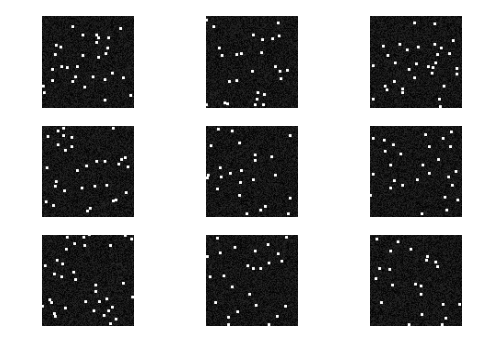

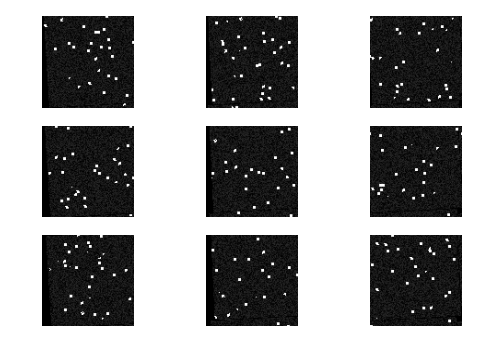

	Initial Error:  1.42291659881e+14


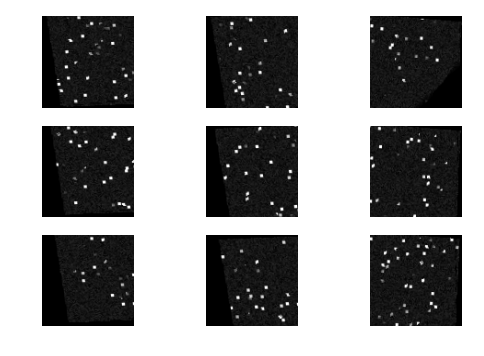

	Final Pipeline Error:  1.16606238065e+14
	Final Random Error:  1.39424630307e+14
	Pipeline Reduction Ratio:  0.180512489892
	Random Reduction Ratio:  0.0201489642911





Executing Test:  2
[[ 0.9960595  -0.05358868 -0.07066629 -2.43300489]
 [ 0.05579327  0.99800348  0.02960017  0.19807002]
 [ 0.06893897 -0.03342624  0.99706073 -1.66653707]
 [ 0.          0.          0.          1.        ]]


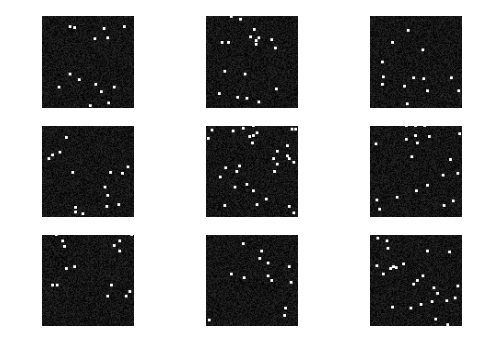

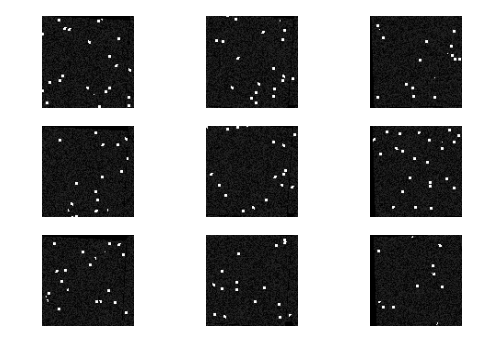

	Initial Error:  1.10827181079e+14


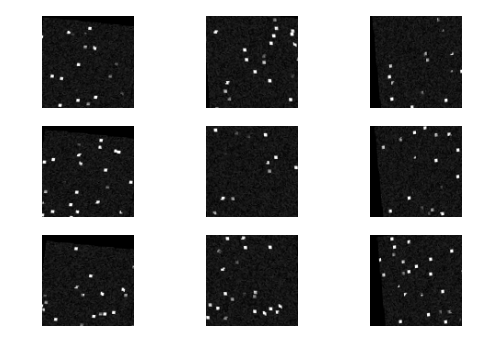

	Final Pipeline Error:  9.1867539219e+13
	Final Random Error:  1.09847061557e+14
	Pipeline Reduction Ratio:  0.171073933985
	Random Reduction Ratio:  0.00884367456215





Executing Test:  3
[[ 0.99732139  0.04013356  0.06115013 -1.70953417]
 [-0.03676247  0.99779332 -0.05529023 -1.6155665 ]
 [-0.06323419  0.0528941   0.99659603 -0.64047716]
 [ 0.          0.          0.          1.        ]]


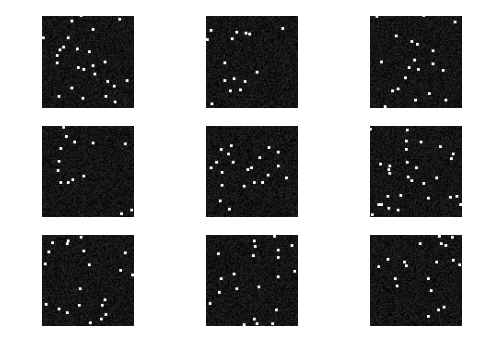

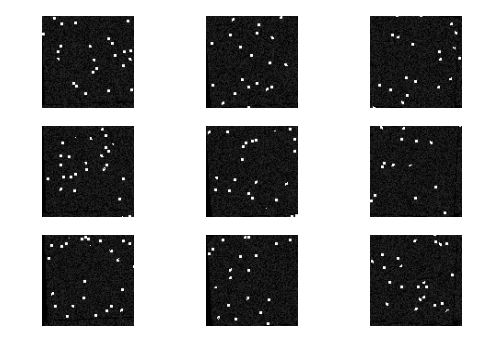

	Initial Error:  1.28953466235e+14


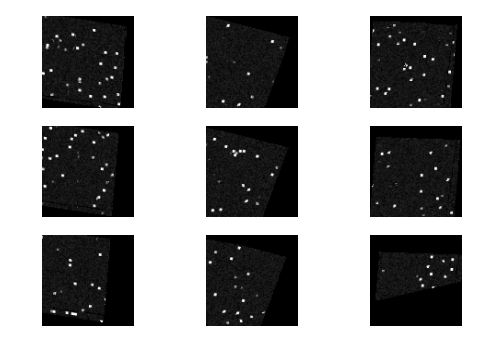

	Final Pipeline Error:  1.03235520739e+14
	Final Random Error:  1.27840281262e+14
	Pipeline Reduction Ratio:  0.199435860451
	Random Reduction Ratio:  0.00863245484021





Executing Test:  4
[[  9.99426797e-01  -6.51325901e-04  -3.38475108e-02   6.90659240e-01]
 [ -1.85716728e-03   9.97254485e-01  -7.40273174e-02  -4.60821930e-01]
 [  3.38027978e-02   7.40477452e-02   9.96681645e-01  -1.25641842e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


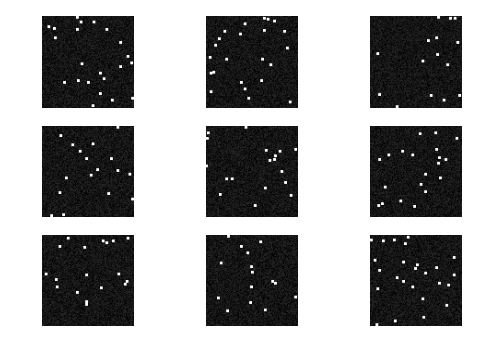

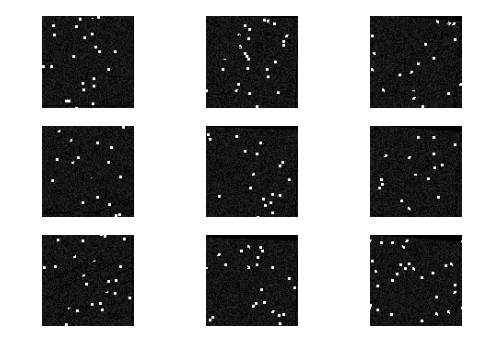

	Initial Error:  1.11631478776e+14


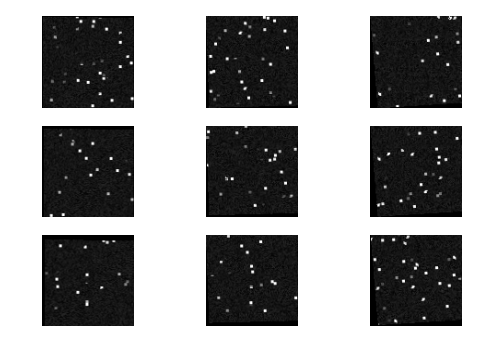

	Final Pipeline Error:  2.81042831173e+13
	Final Random Error:  1.11800548785e+14
	Pipeline Reduction Ratio:  0.748240519381
	Random Reduction Ratio:  -0.00151453703888





Executing Test:  5
[[  9.99774222e-01  -8.17612432e-05   2.12484688e-02  -1.57472222e+00]
 [ -1.10944235e-04   9.99958880e-01   9.06780954e-03   1.71841028e+00]
 [ -2.12483364e-02  -9.06811963e-03   9.99733103e-01  -9.47451794e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


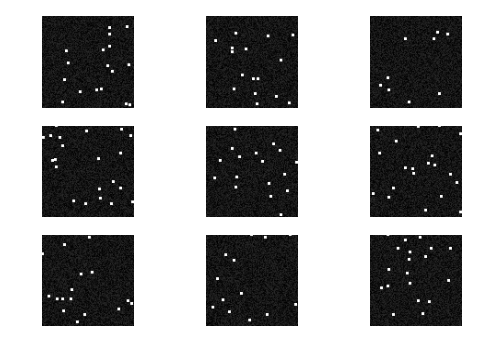

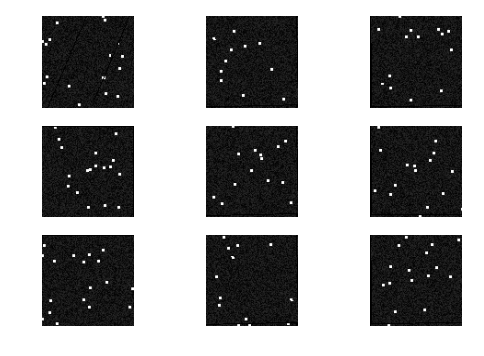

	Initial Error:  1.02676513452e+14


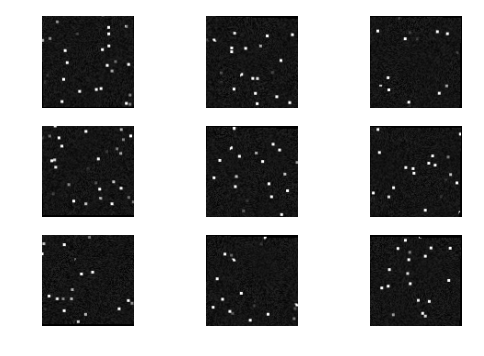

	Final Pipeline Error:  2.39680623284e+13
	Final Random Error:  1.04069375168e+14
	Pipeline Reduction Ratio:  0.766567236046
	Random Reduction Ratio:  -0.013565533814





Executing Test:  6
[[ 0.99906347 -0.00931955  0.04225317 -0.11242906]
 [ 0.00706305  0.99855663  0.05324257  1.50373071]
 [-0.04268838 -0.05289427  0.99768727 -1.17046319]
 [ 0.          0.          0.          1.        ]]


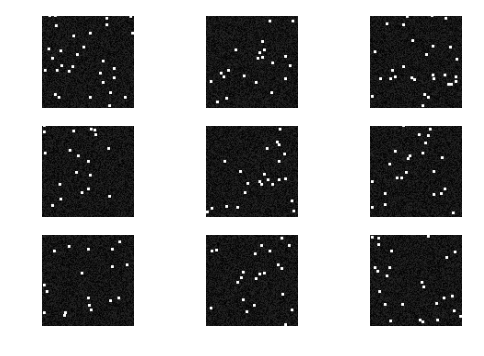

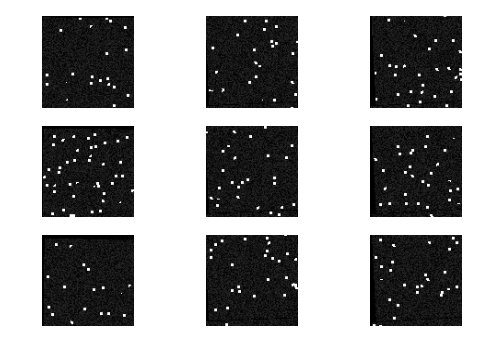

	Initial Error:  1.41717129813e+14


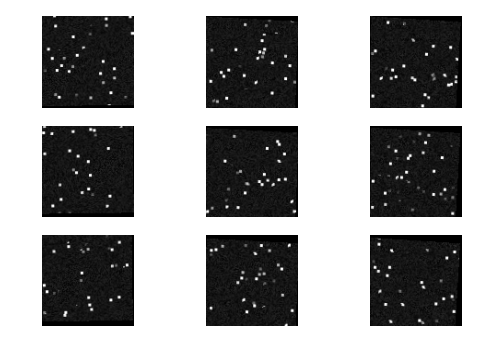

	Final Pipeline Error:  3.46211546509e+13
	Final Random Error:  1.35600776542e+14
	Pipeline Reduction Ratio:  0.755702400293
	Random Reduction Ratio:  0.0431588847378





Executing Test:  7
[[ 0.99905075  0.03903009  0.01934554 -0.42268497]
 [-0.03918628  0.99920178  0.00776158  0.17259958]
 [-0.01902716 -0.00851229  0.99978273 -2.36468444]
 [ 0.          0.          0.          1.        ]]


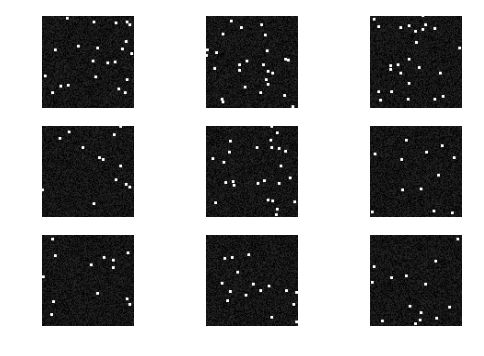

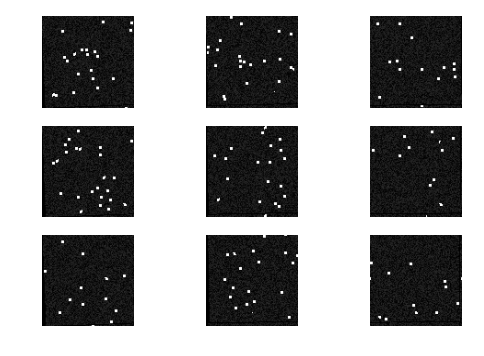

	Initial Error:  1.14162322652e+14


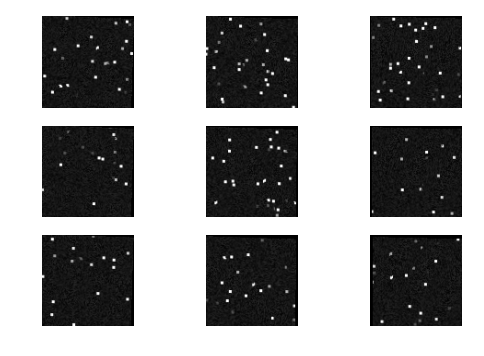

	Final Pipeline Error:  3.17934565867e+13
	Final Random Error:  1.1004376578e+14
	Pipeline Reduction Ratio:  0.721506571974
	Random Reduction Ratio:  0.0360763234004





Executing Test:  8
[[ 0.99733429  0.01254852  0.07188081 -1.94959651]
 [-0.00969622  0.9991569  -0.03989334  1.21892214]
 [-0.07232081  0.03909002  0.99661511  2.4545485 ]
 [ 0.          0.          0.          1.        ]]


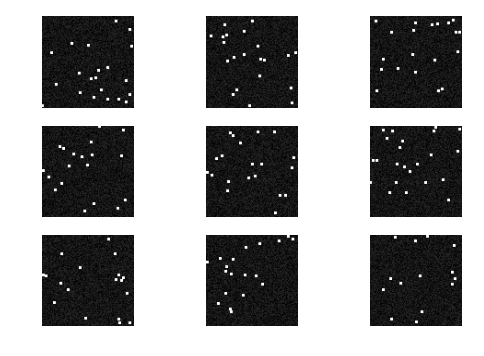

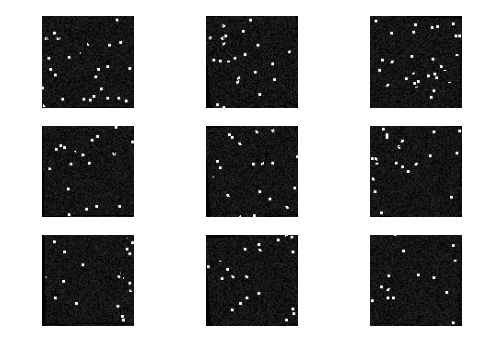

	Initial Error:  1.06954936349e+14


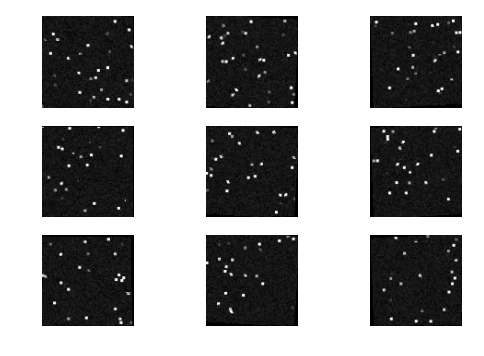

	Final Pipeline Error:  3.76107883342e+13
	Final Random Error:  1.17508452754e+14
	Pipeline Reduction Ratio:  0.648349205582
	Random Reduction Ratio:  -0.098672550932





Executing Test:  9
[[ 0.99941517 -0.02465037 -0.02369974  2.00155554]
 [ 0.02613483  0.99757451  0.06451408  1.42308155]
 [ 0.02205196 -0.06509574  0.99763533  0.61196934]
 [ 0.          0.          0.          1.        ]]


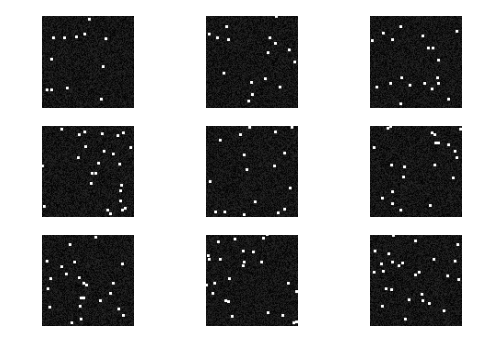

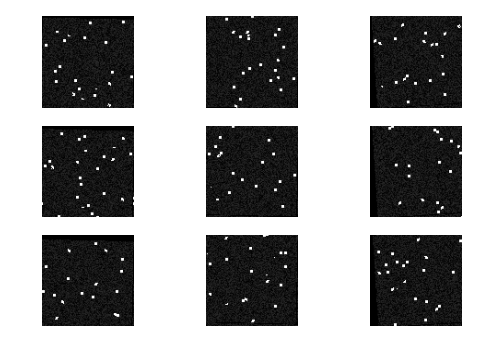

	Initial Error:  1.20598583433e+14


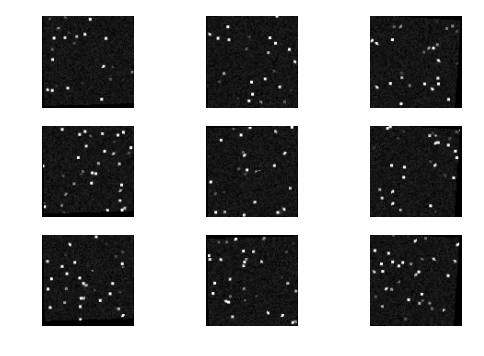

	Final Pipeline Error:  2.61896640778e+13
	Final Random Error:  1.19561635095e+14
	Pipeline Reduction Ratio:  0.782836055514
	Random Reduction Ratio:  0.00859834592958





Executing Test:  10
[[ 0.99760989  0.03818573  0.05758775 -1.45578597]
 [-0.04092608  0.99804757  0.04718169 -0.62358136]
 [-0.05567364 -0.04942576  0.99722492 -2.41564212]
 [ 0.          0.          0.          1.        ]]


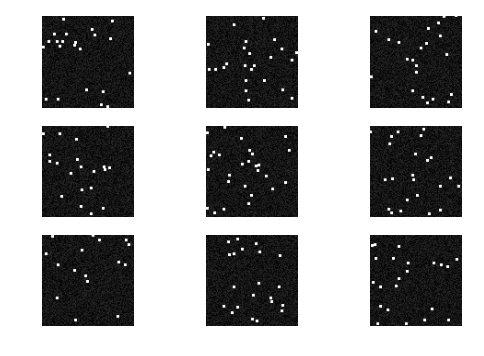

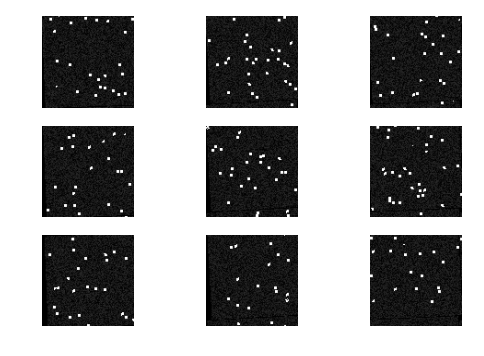

	Initial Error:  1.22867904396e+14


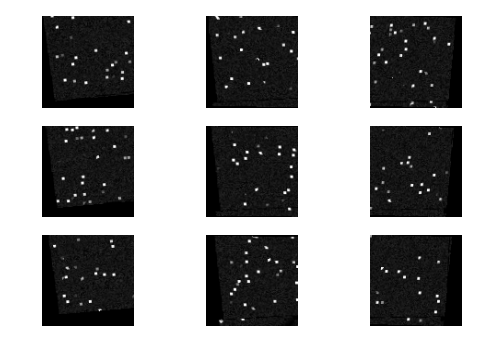

	Final Pipeline Error:  1.00974490041e+14
	Final Random Error:  1.22765155797e+14
	Pipeline Reduction Ratio:  0.178186601798
	Random Reduction Ratio:  0.000836252553256





Executing Test:  11
[[ 0.99645253 -0.05719615  0.06173293 -0.10212609]
 [ 0.06013919  0.99708679 -0.04691699  0.49123069]
 [-0.05886962  0.05046312  0.99698939  2.168637  ]
 [ 0.          0.          0.          1.        ]]


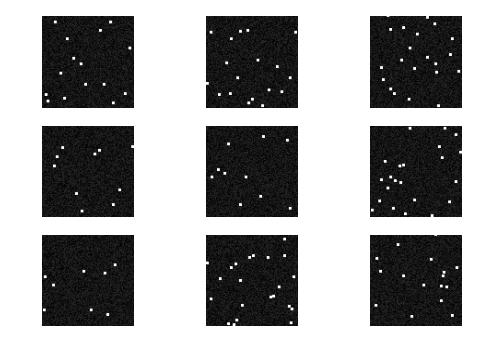

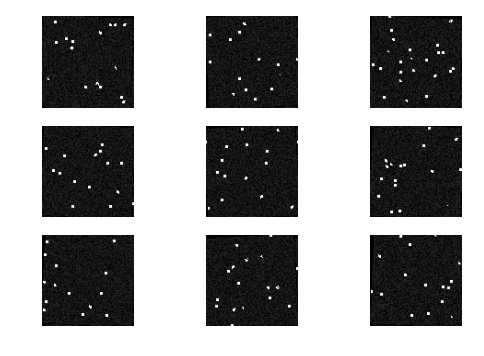

	Initial Error:  9.45743051473e+13


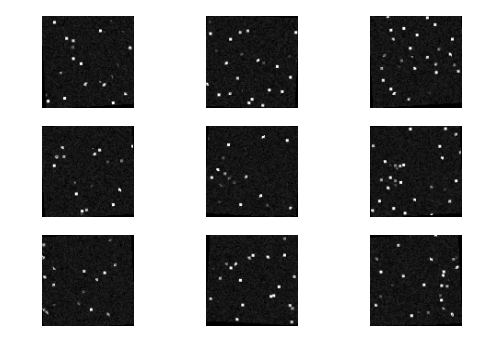

	Final Pipeline Error:  2.3417922927e+13
	Final Random Error:  1.02136070461e+14
	Pipeline Reduction Ratio:  0.752385990143
	Random Reduction Ratio:  -0.0799558114839





Executing Test:  12
[[ 0.99625656  0.07588327  0.0414077   1.83842493]
 [-0.07425855  0.99645803 -0.03945963  0.05849314]
 [-0.04425536  0.03623704  0.99836283 -0.96974883]
 [ 0.          0.          0.          1.        ]]


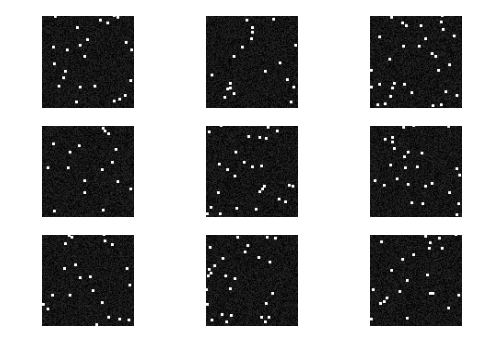

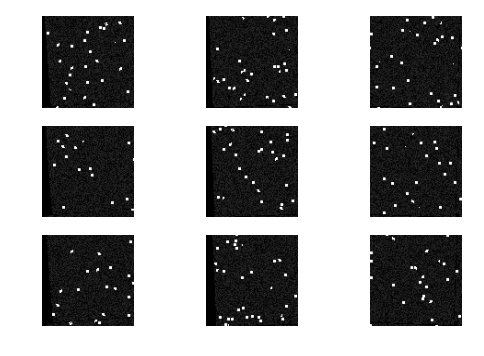

	Initial Error:  1.39863130547e+14


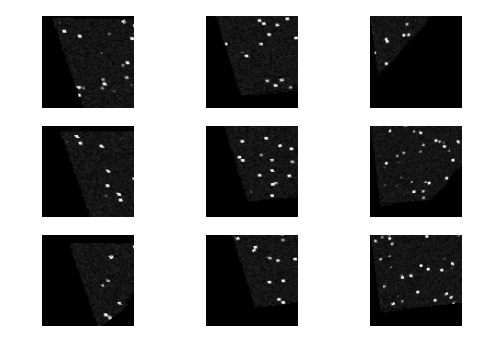

	Final Pipeline Error:  1.12752293096e+14
	Final Random Error:  1.38575770851e+14
	Pipeline Reduction Ratio:  0.193838342845
	Random Reduction Ratio:  0.00920442500338





Executing Test:  13
[[ 0.99928405 -0.03703263  0.00774403  2.34981234]
 [ 0.03686452  0.9991032   0.02082774 -1.2303801 ]
 [-0.00850839 -0.02052735  0.99975309 -2.43902967]
 [ 0.          0.          0.          1.        ]]


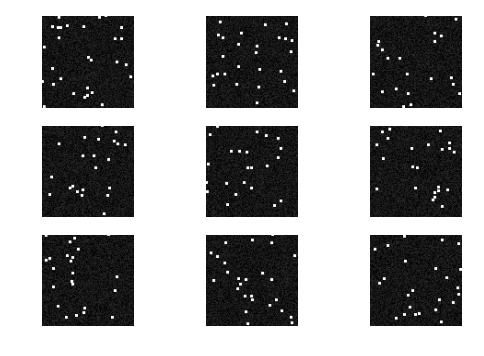

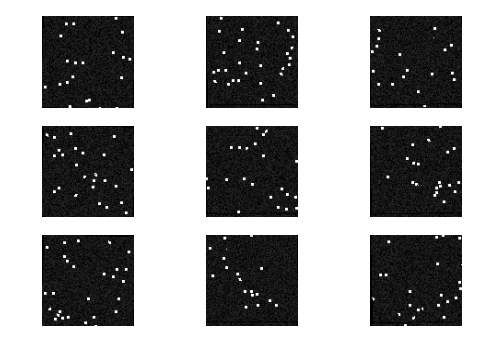

	Initial Error:  1.41528270895e+14


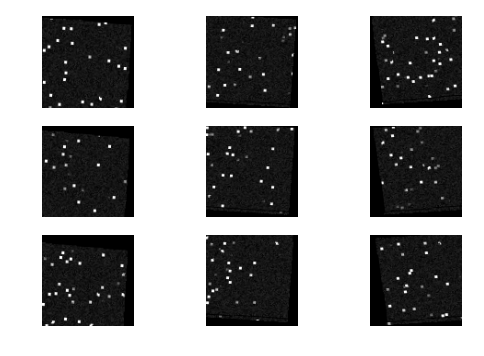

	Final Pipeline Error:  1.13786390613e+14
	Final Random Error:  1.32725446389e+14
	Pipeline Reduction Ratio:  0.196016528054
	Random Reduction Ratio:  0.0621983470145





Executing Test:  14
[[ 0.99764671  0.00827992 -0.06806237  1.59105615]
 [-0.00750715  0.99990452  0.01160177 -2.29604645]
 [ 0.06815193 -0.01106352  0.99761361 -0.70011287]
 [ 0.          0.          0.          1.        ]]


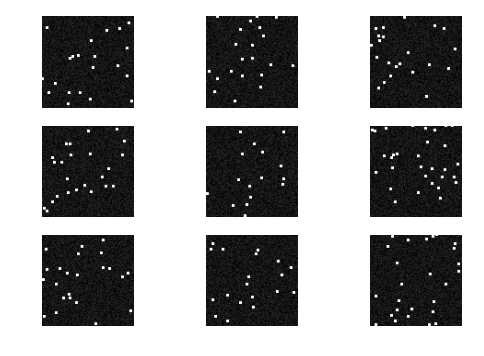

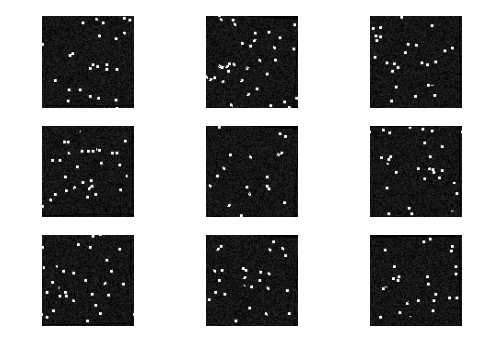

	Initial Error:  1.38255437987e+14


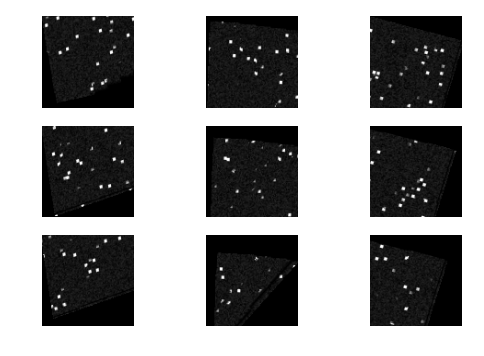

	Final Pipeline Error:  1.12794477892e+14
	Final Random Error:  1.36259354609e+14
	Pipeline Reduction Ratio:  0.184158832852
	Random Reduction Ratio:  0.0144376482207





Executing Test:  15
[[ 0.99830723  0.05659256  0.01341497 -1.13982466]
 [-0.05698891  0.99788474  0.03127797 -1.94351597]
 [-0.0116165  -0.03198953  0.9994207   0.13894946]
 [ 0.          0.          0.          1.        ]]


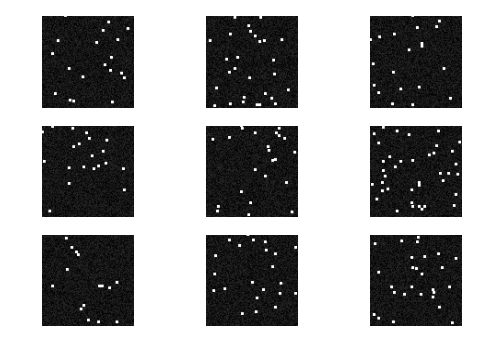

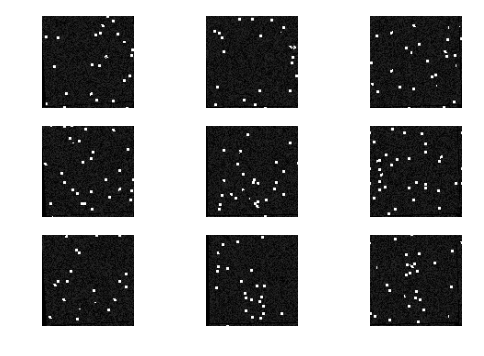

	Initial Error:  1.22757713747e+14


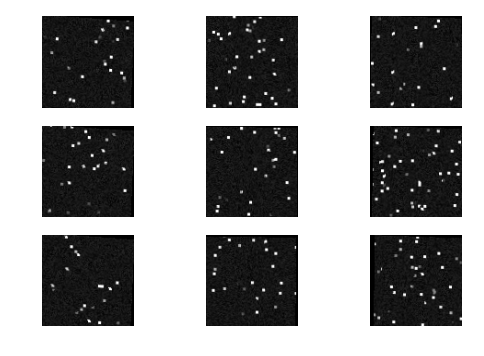

	Final Pipeline Error:  3.76560500609e+13
	Final Random Error:  1.25241931098e+14
	Pipeline Reduction Ratio:  0.693249011313
	Random Reduction Ratio:  -0.0202367515252





Executing Test:  16
[[ 0.99789538 -0.05485491  0.03457948  1.62283072]
 [ 0.05241917  0.99632136  0.06779364  2.31128743]
 [-0.03817109 -0.06583833  0.99709994 -0.5636553 ]
 [ 0.          0.          0.          1.        ]]


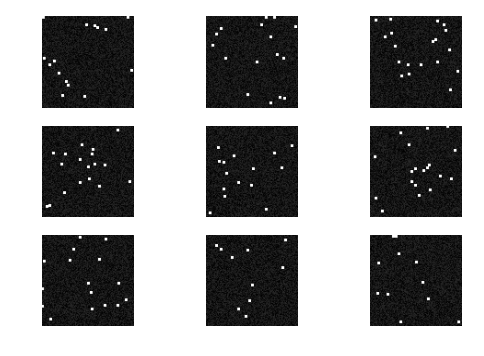

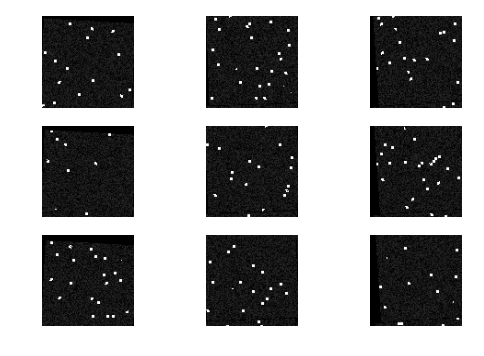

	Initial Error:  9.65954115668e+13


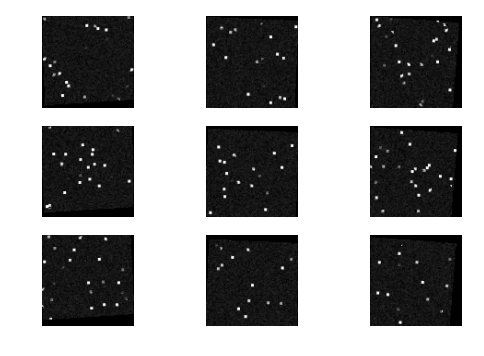

	Final Pipeline Error:  3.03956714275e+13
	Final Random Error:  9.14875544258e+13
	Pipeline Reduction Ratio:  0.685330069675
	Random Reduction Ratio:  0.0528788796296





Executing Test:  17
[[ 0.99902514 -0.03925693 -0.02019048  0.37756283]
 [ 0.03961028  0.99906353  0.01740923 -0.66411847]
 [ 0.01948814 -0.018192    0.99964457 -1.52613124]
 [ 0.          0.          0.          1.        ]]


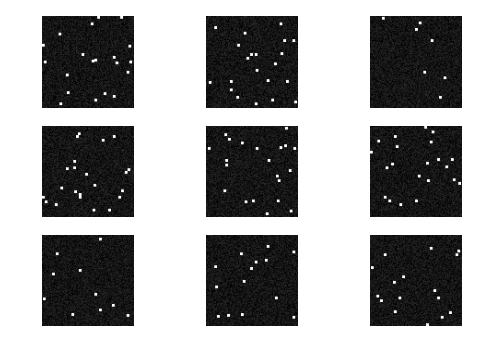

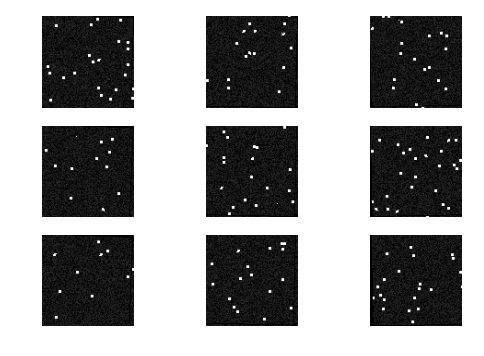

	Initial Error:  9.75023064886e+13


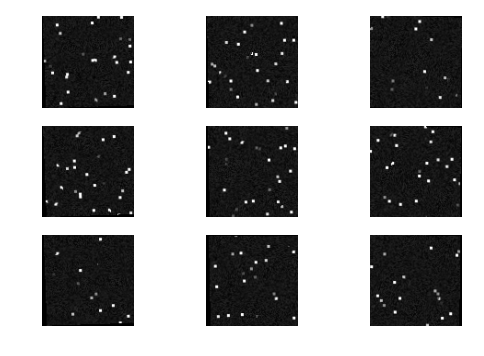

	Final Pipeline Error:  2.61521252444e+13
	Final Random Error:  9.82939456334e+13
	Pipeline Reduction Ratio:  0.731779419522
	Random Reduction Ratio:  -0.00811918377375





Executing Test:  18
[[  9.97971917e-01  -4.12907991e-02   4.84471083e-02   1.11813650e+00]
 [  4.13981112e-02   9.99141994e-01  -1.21330301e-03  -1.41918232e+00]
 [ -4.83554422e-02   3.21646111e-03   9.98825012e-01  -2.75156840e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


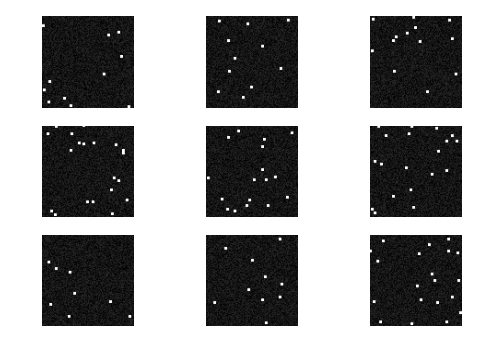

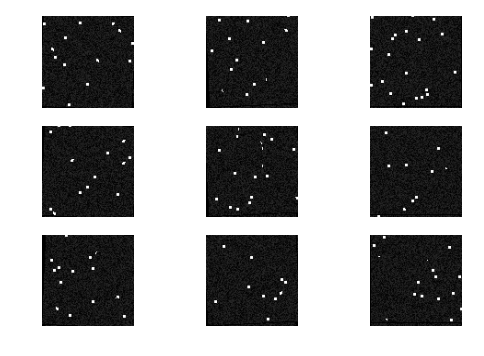

	Initial Error:  9.5469212611e+13


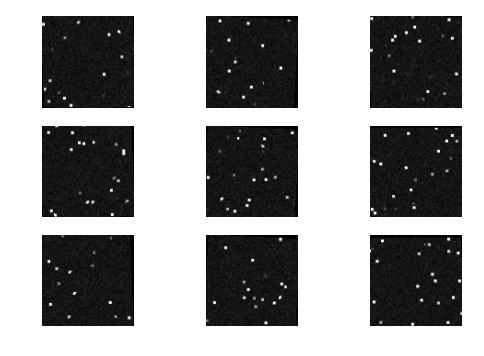

	Final Pipeline Error:  2.44894257169e+13
	Final Random Error:  9.82224574021e+13
	Pipeline Reduction Ratio:  0.743483526813
	Random Reduction Ratio:  -0.028839085563





Executing Test:  19
[[ 0.99820939  0.01472842 -0.05797491 -1.28055976]
 [-0.01120457  0.99809651  0.06064497 -0.6815341 ]
 [ 0.05875776 -0.05988679  0.99647433 -0.44544651]
 [ 0.          0.          0.          1.        ]]


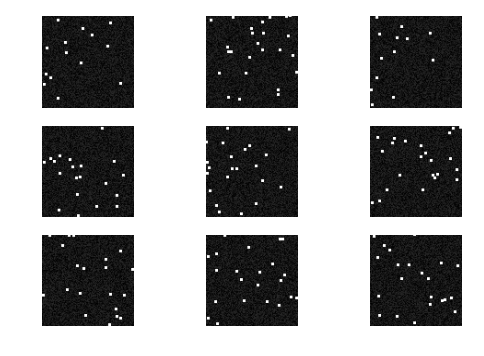

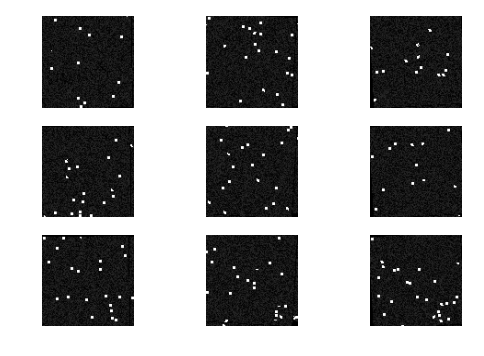

	Initial Error:  1.15484722889e+14


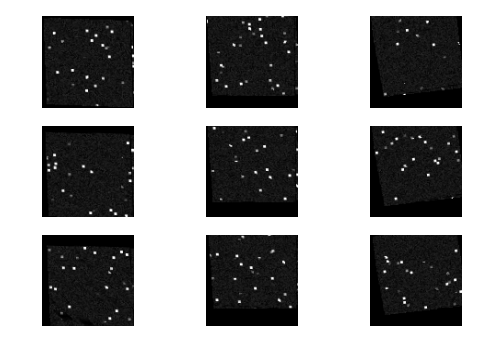

	Final Pipeline Error:  9.5351664746e+13
	Final Random Error:  1.14829158267e+14
	Pipeline Reduction Ratio:  0.174335250924
	Random Reduction Ratio:  0.00567663501755





Executing Test:  20
[[  9.98092491e-01  -4.59528688e-02   4.12275863e-02   2.40539337e+00]
 [  4.59341914e-02   9.98943486e-01   1.40069895e-03   7.26466614e-02]
 [ -4.12483949e-02   4.95728728e-04   9.99148800e-01   2.18699283e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


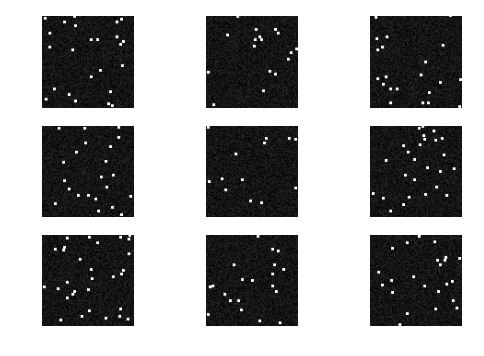

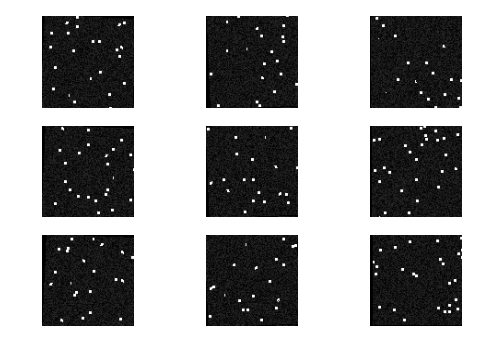

	Initial Error:  1.16118368976e+14


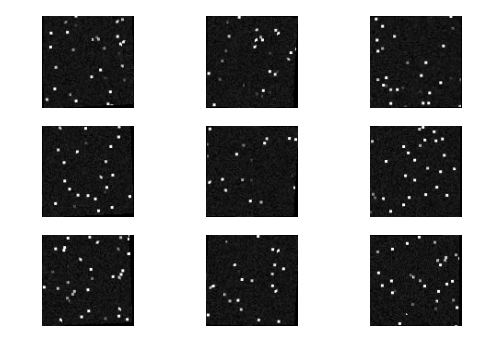

	Final Pipeline Error:  3.72683433954e+13
	Final Random Error:  1.2024651376e+14
	Pipeline Reduction Ratio:  0.679048683476
	Random Reduction Ratio:  -0.0355511778218





Average Error Reduction Ratio:
	Pipeline:  0.509301826527
	Random:  -0.000788189837615

Error Reduction Ratio Variance
	Pipeline:  0.0711990201533
	Random:  0.00148309283228


In [5]:
pipelineDat = []
randDat = []
errorList = []

for i in range(20):
    print '\nExecuting Test: ', i+1
    
    #generate an display data
    itkVolume, rigidVolume, curTransform = generateTestVolume()
    print curTransform
    ndreg.imgShow(itkVolume, vmax=60000)
    ndreg.imgShow(rigidVolume, vmax=60000)
    
    #calculate initial error
    initialErr = np.sum((itk.GetArrayFromImage(itkVolume)-itk.GetArrayFromImage(rigidVolume))**2)
    print '\tInitial Error: ', initialErr
    
    #perform transform
    transform = register(rigidVolume, itkVolume)
    resultVolume = ndreg.imgApplyAffine(rigidVolume, transform, size=itkVolume.GetSize(), spacing=itkVolume.GetSpacing())
    ndreg.imgShow(resultVolume, vmax=60000)
    #perform random transform
    randMatrix = applyRigid(itk.GetArrayFromImage(rigidVolume), getTransform())

    
    #calculate final error
    finalPipeErr = np.sum((itk.GetArrayFromImage(itkVolume)-itk.GetArrayFromImage(resultVolume))**2)
    finalRandErr = np.sum((itk.GetArrayFromImage(itkVolume)-randMatrix)**2)
    print '\tFinal Pipeline Error: ', finalPipeErr
    print '\tFinal Random Error: ', finalRandErr

    #get the reduction in error
    pipeRatio = (initialErr - finalPipeErr)/initialErr 
    randRatio = (initialErr - finalRandErr)/initialErr 
    pipelineDat.append(pipeRatio)
    randDat.append(randRatio)
    errorList.append(initialErr)
    
    print '\tPipeline Reduction Ratio: ', pipeRatio
    print '\tRandom Reduction Ratio: ', randRatio
    print '\n\n\n'
    
print '\nAverage Error Reduction Ratio:'
print '\tPipeline: ', np.average(pipelineDat)
print '\tRandom: ', np.average(randDat)

print '\nError Reduction Ratio Variance'
print '\tPipeline: ', np.var(pipelineDat)
print '\tRandom: ', np.var(randDat)

    


#### 3. Analyze Results
There is an interestingly high variance in the NDReg pipeline's performance. I graphed the reduction ratio in a histogram below to demonstrate this observation.

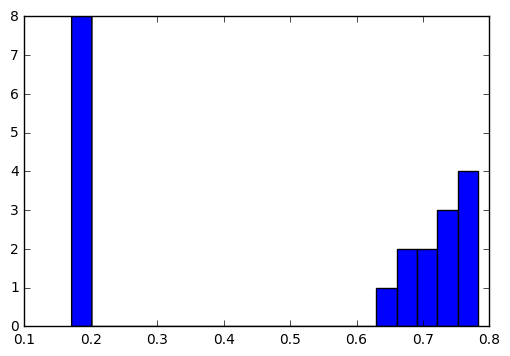

In [6]:
import matplotlib.pyplot as plt
plt.hist(pipelineDat, 20)
plt.show()

There is an obvious bimodal tendency to the distribution of these results. I am not yet sure what may be causing these highly variant results, but I will continue to investigate. I intend to show these to Kwame on Tuesday during our meeting in hope that he can shed some light on what the cause may be.

In terms of performance, the algorithm does perform far better than random. However, th error reduction rate is substantially skiewed by the 8 extremely low scores in the test results. My initial thought is that the pipeline's error reduction rate may be based on the magnitude of the initial error. Below is a graph of error reduction rate vs the initial error.

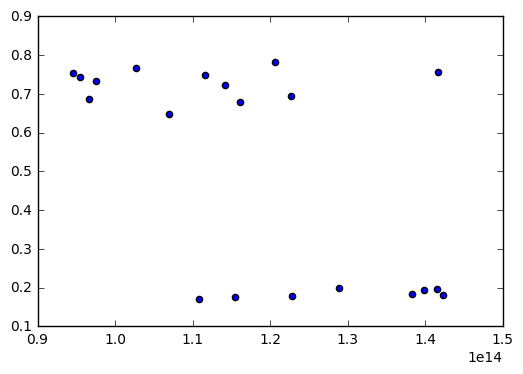

In [7]:
plt.scatter(errorList, pipelineDat)
plt.show()


The nonlinear nature of the scatter plot is evidence that there is some other source of noise causing poor performance in NDReg beyond magnitude of initial error. 